In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import datetime
from time import time
from tqdm import tqdm
import torch

import src.mace.utils as utils
import src.mace.input as input
import src.mace.dataset as dataset
import src.mace.mace as mace
import src.mace.loss as loss
import src.mace.train as train
import src.mace.test as test
import src.mace.load as load

Setup

In [3]:
# Timing (questionable for a jupyter notebook)
start_time = time()

# Read input file
now = datetime.datetime.now()
# name = "20241211_114449"
name = "20241211_210455"
input_file = "./input/local.in"
path = f"./models/{name:s}"
output_location = "./models/"

# Set up PyTorch
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 
kwargs = {'num_workers': 1, 'pin_memory': True} 

# Make output directories
utils.makeOutputDir(path)
utils.makeOutputDir(path+'/nn')

'./models/20241211_210455/nn'

Load inputs

In [4]:
input_data = input.Input(input_file, name)
input_data.print()
traindata, testdata, data_loader, test_loader = dataset.get_data(
    dt_fract=input_data.dt_fract,
    n_L96=input_data.n_dim,
    nb_samples=input_data.nb_samples,
    batch_size=batch_size, 
    nb_test=input_data.nb_test,
    kwargs=kwargs,
    )
# meta = input_data.make_meta(path)

------------------------------
Name: 20241211_210455
------------------------------
     inputfile: ./input/local.in
      # hidden: 2
       ae type: simple
# z dimensions: 8
        scheme: loc
  # evolutions: 1
     loss type: abs_grd_idn
      # epochs: 10
 learning rate: 1e-05

Dataset:
------------------------------
  total # of samples: 120
#   training samples: 84
# validation samples: 36
               ratio: 0.3
     #  test samples: 5


Load model

In [5]:
trained = load.Trained_MACE(
    p_dim=1,
    n_dim=input_data.n_dim,
    outloc=output_location,
    dirname=name,
    # epoch=5,
    )
meta = trained.get_meta()
model = trained.model

in simple
8
The model has 135988 trainable parameters


Test model on the test samples

------------------------------
Name: 20241211_210455
------------------------------
     inputfile: ./input/local.in
      # hidden: 2
       ae type: simple
# z dimensions: 8
        scheme: loc
  # evolutions: 1
     loss type: abs_grd_idn
      # epochs: 10
 learning rate: 1e-05



  0%|          | 0/5 [00:00<?, ?it/s]


Errors (following Eq. 23 of Maes et al., 2024):
      Step error: 252.838
 Evolution error: 272.106

>>> Plotting...

Step test plot saved as ./models/20241211_210455/step43.png
Evolution test plot saved as ./models/20241211_210455/evol43.png


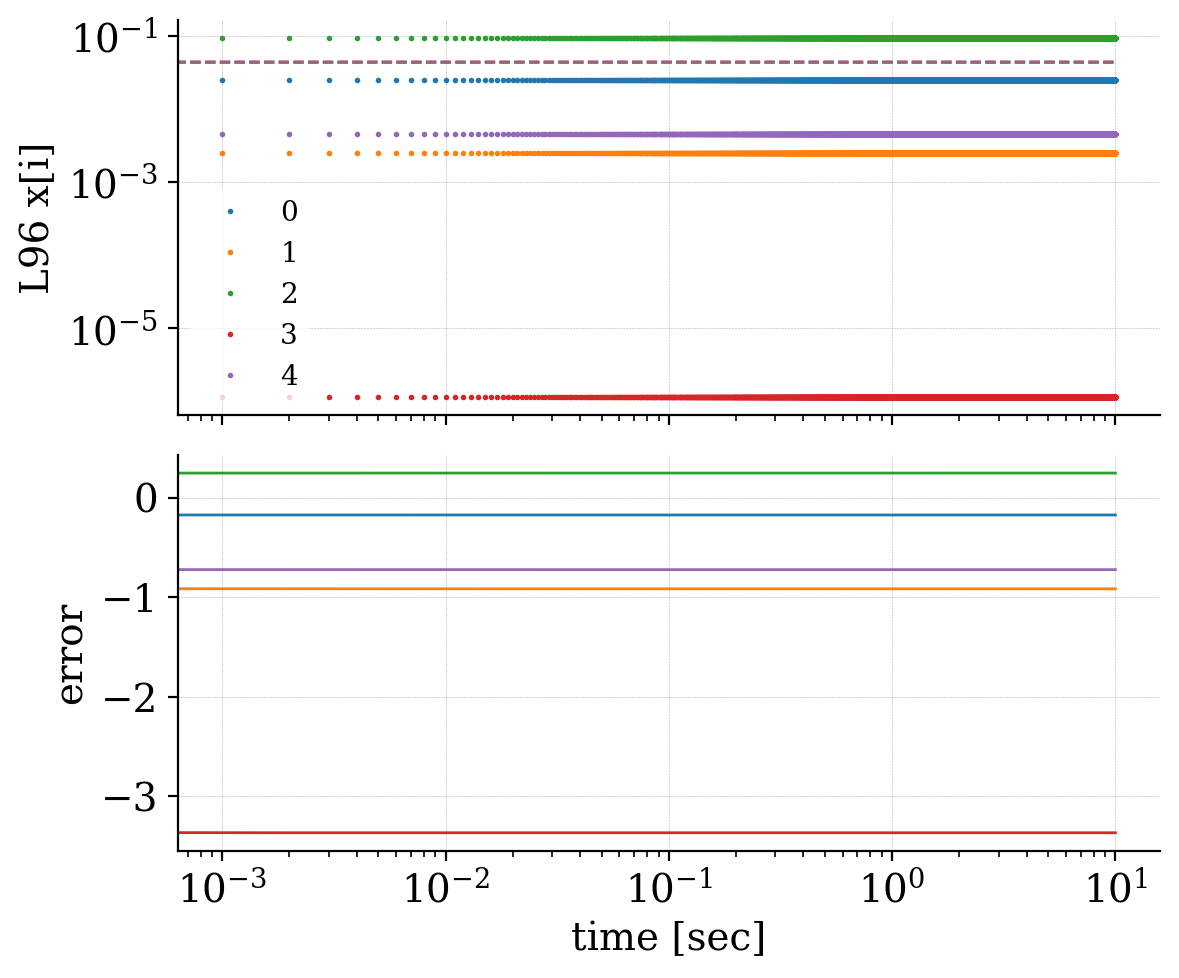

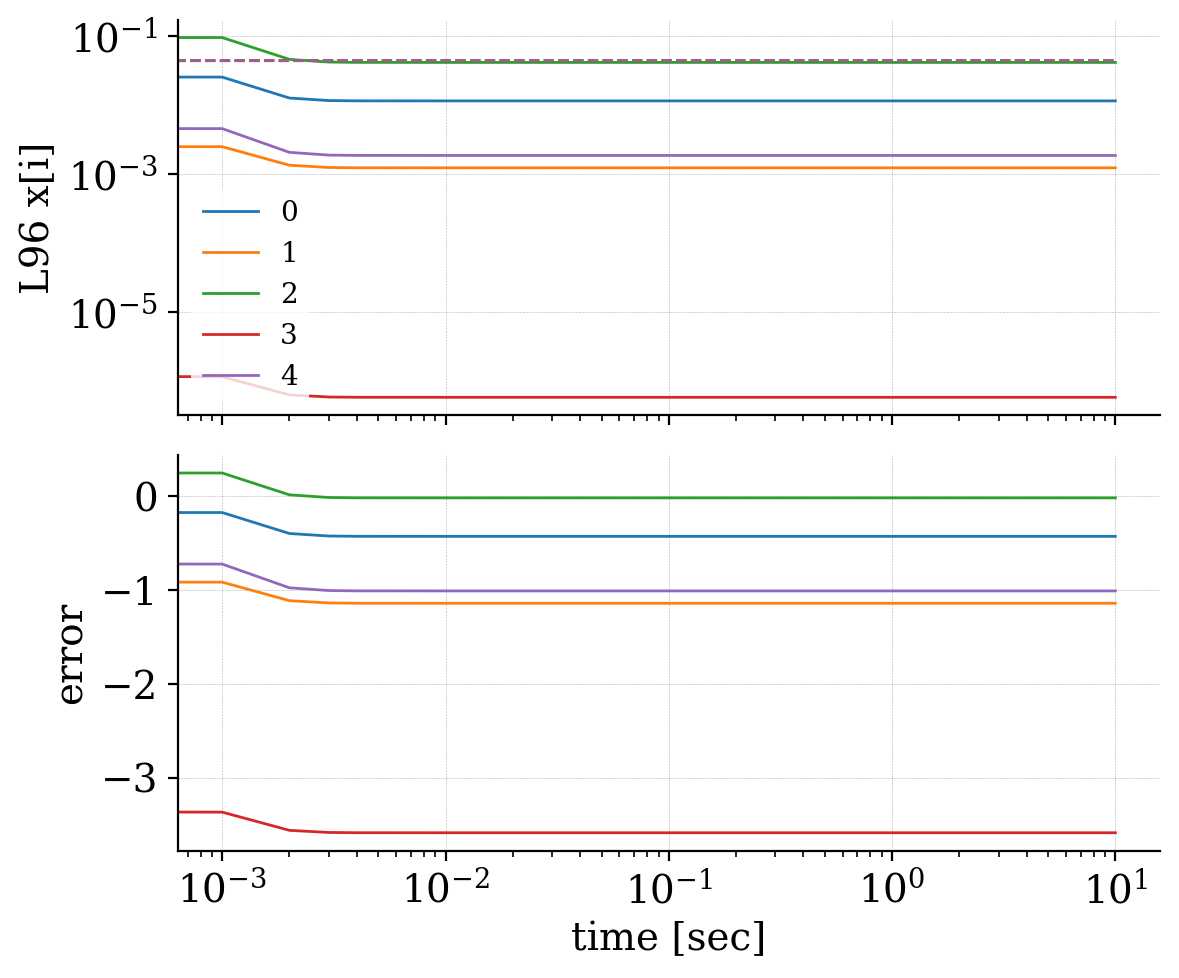

 20%|██        | 1/5 [00:21<01:26, 21.65s/it]


Errors (following Eq. 23 of Maes et al., 2024):
      Step error: 99.916
 Evolution error: 103.792

>>> Plotting...

Step test plot saved as ./models/20241211_210455/step2.png
Evolution test plot saved as ./models/20241211_210455/evol2.png


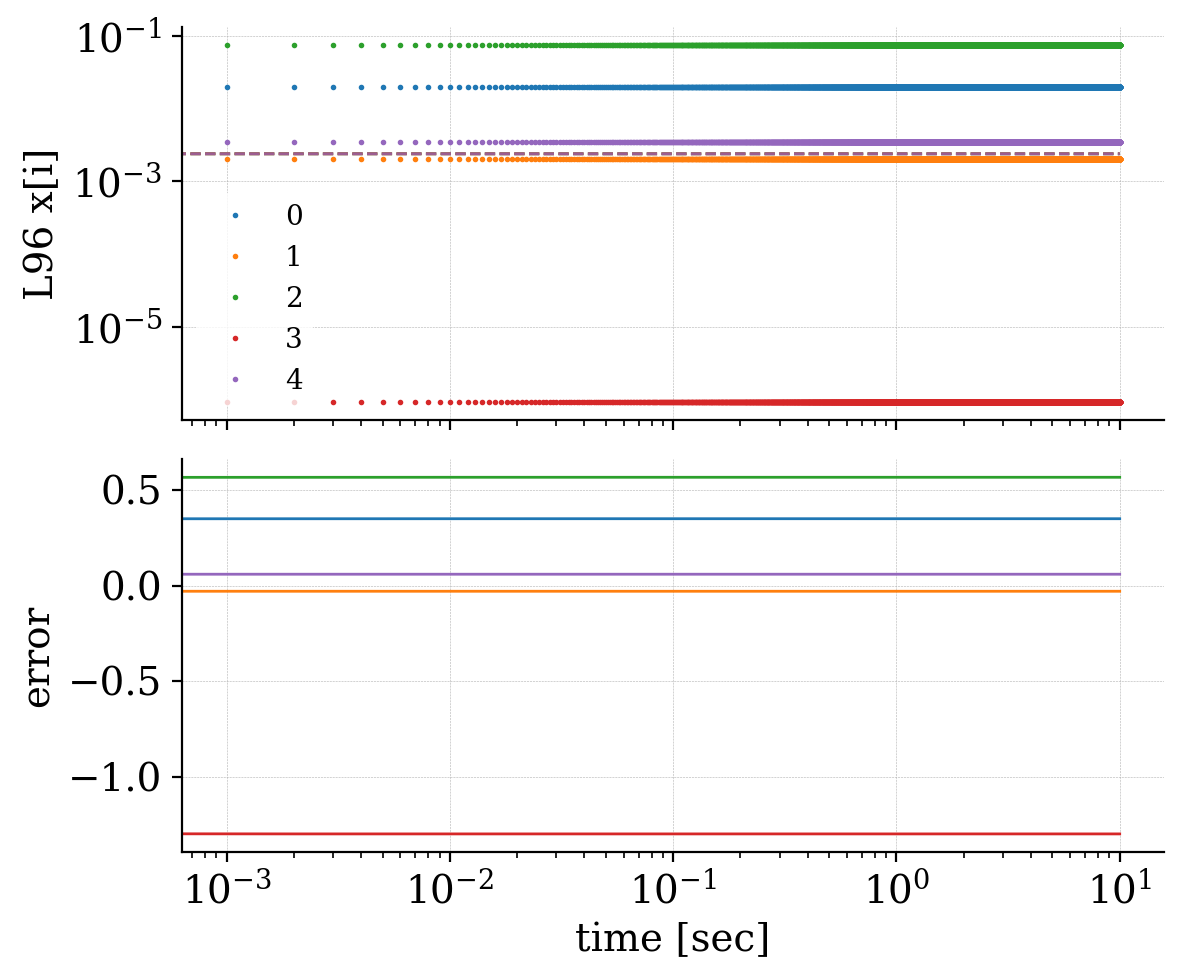

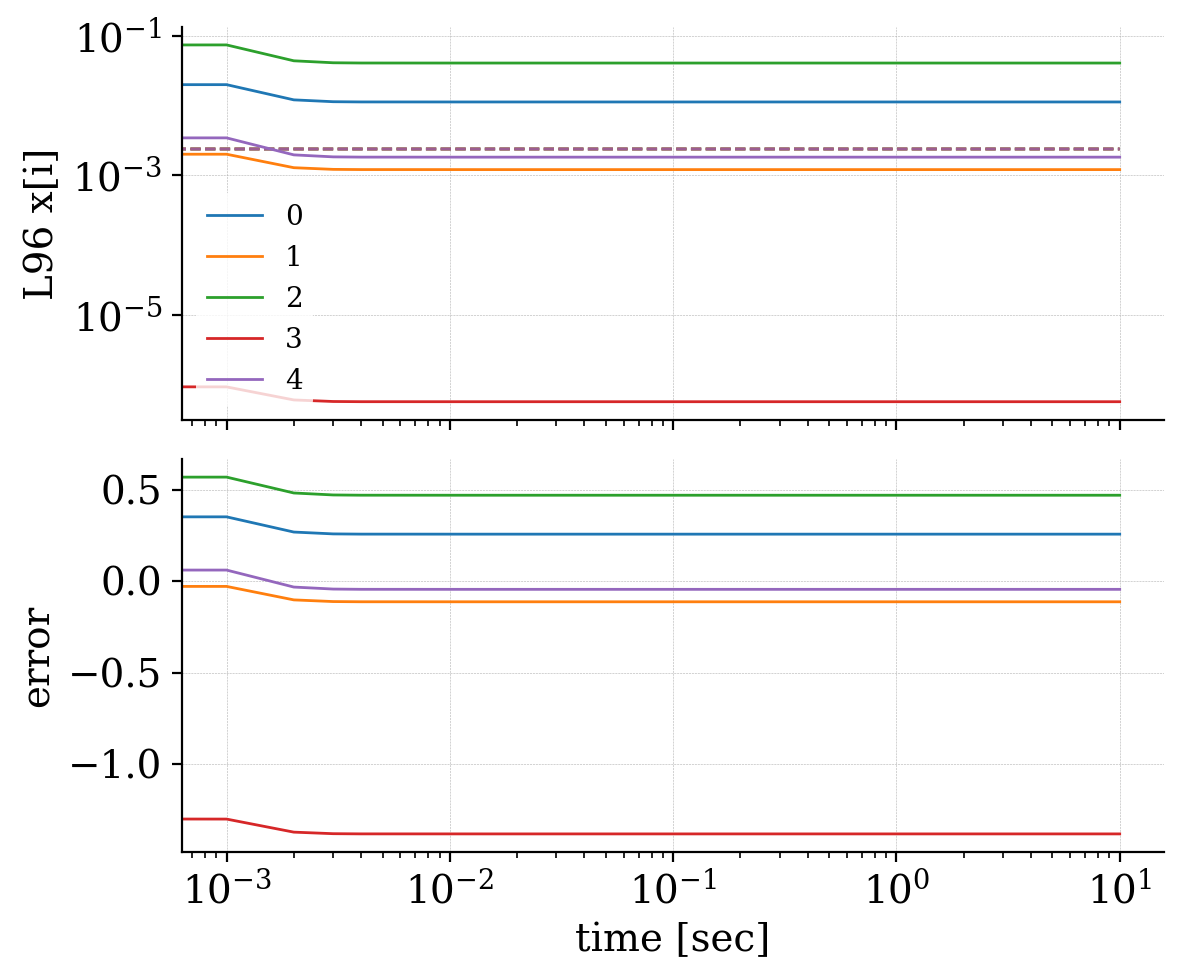

 40%|████      | 2/5 [00:46<01:11, 23.80s/it]


Errors (following Eq. 23 of Maes et al., 2024):
      Step error: 90.989
 Evolution error: 94.047

>>> Plotting...

Step test plot saved as ./models/20241211_210455/step1.png
Evolution test plot saved as ./models/20241211_210455/evol1.png


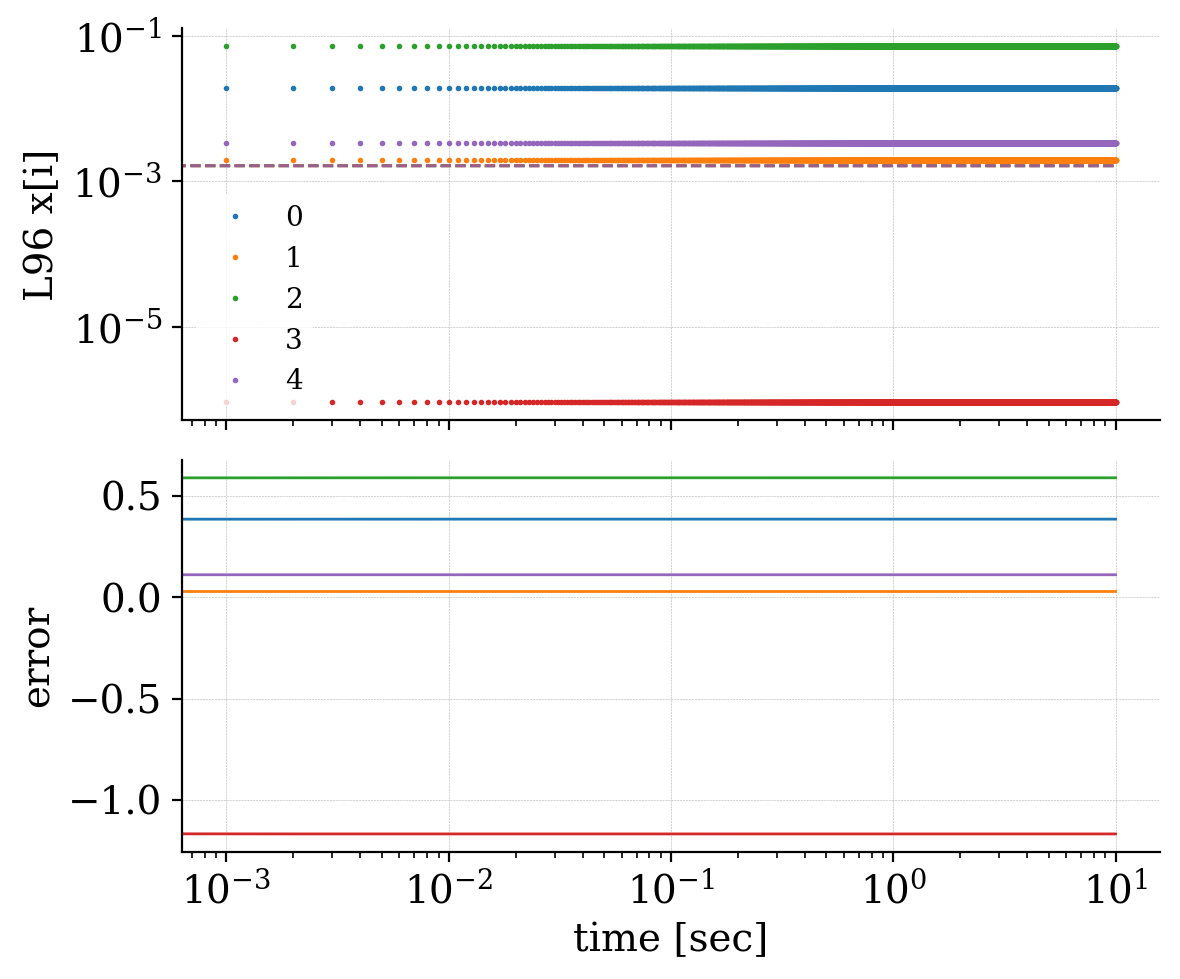

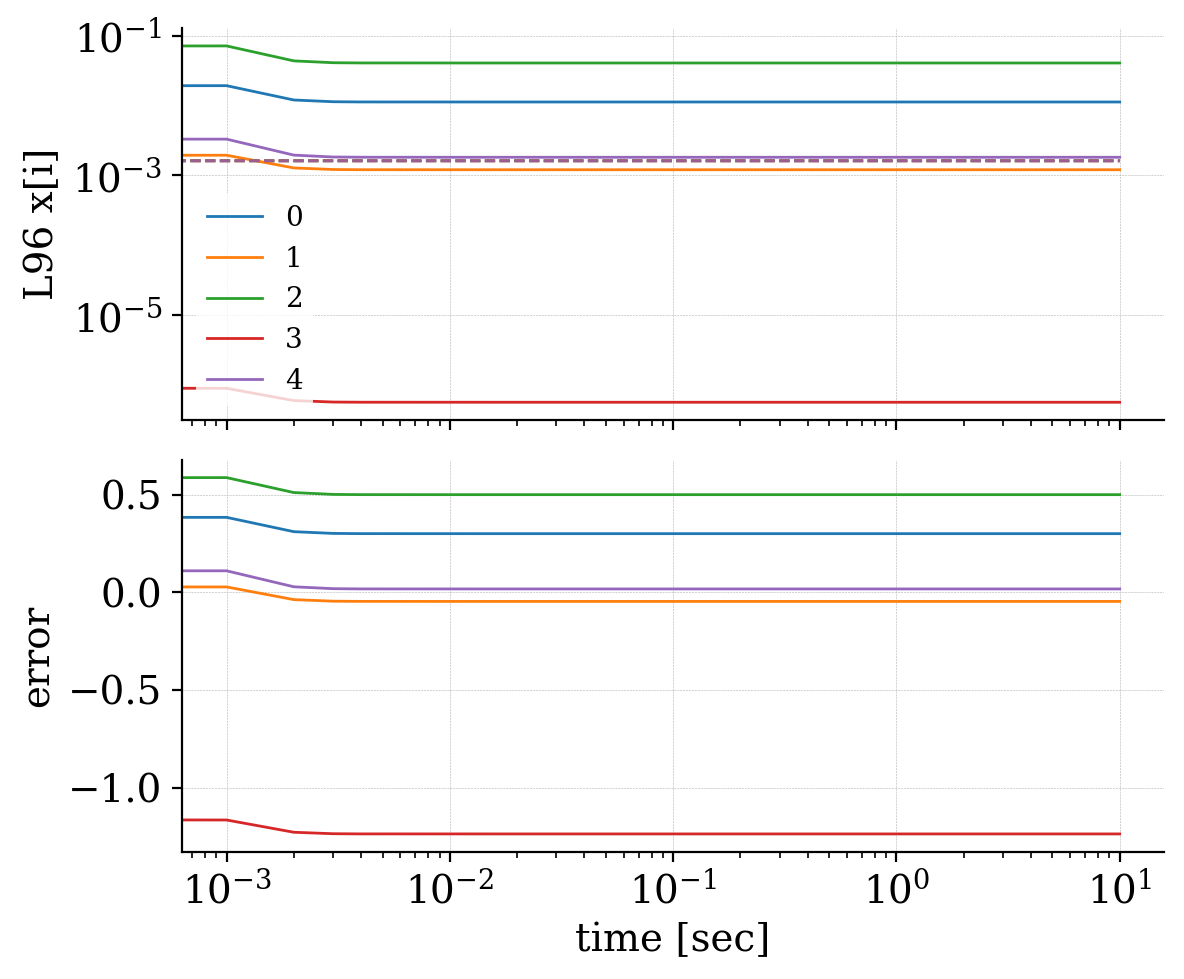

 60%|██████    | 3/5 [01:10<00:47, 23.58s/it]


Errors (following Eq. 23 of Maes et al., 2024):
      Step error: 1475.948
 Evolution error: 1394.37

>>> Plotting...

Step test plot saved as ./models/20241211_210455/step31318.png
Evolution test plot saved as ./models/20241211_210455/evol31318.png


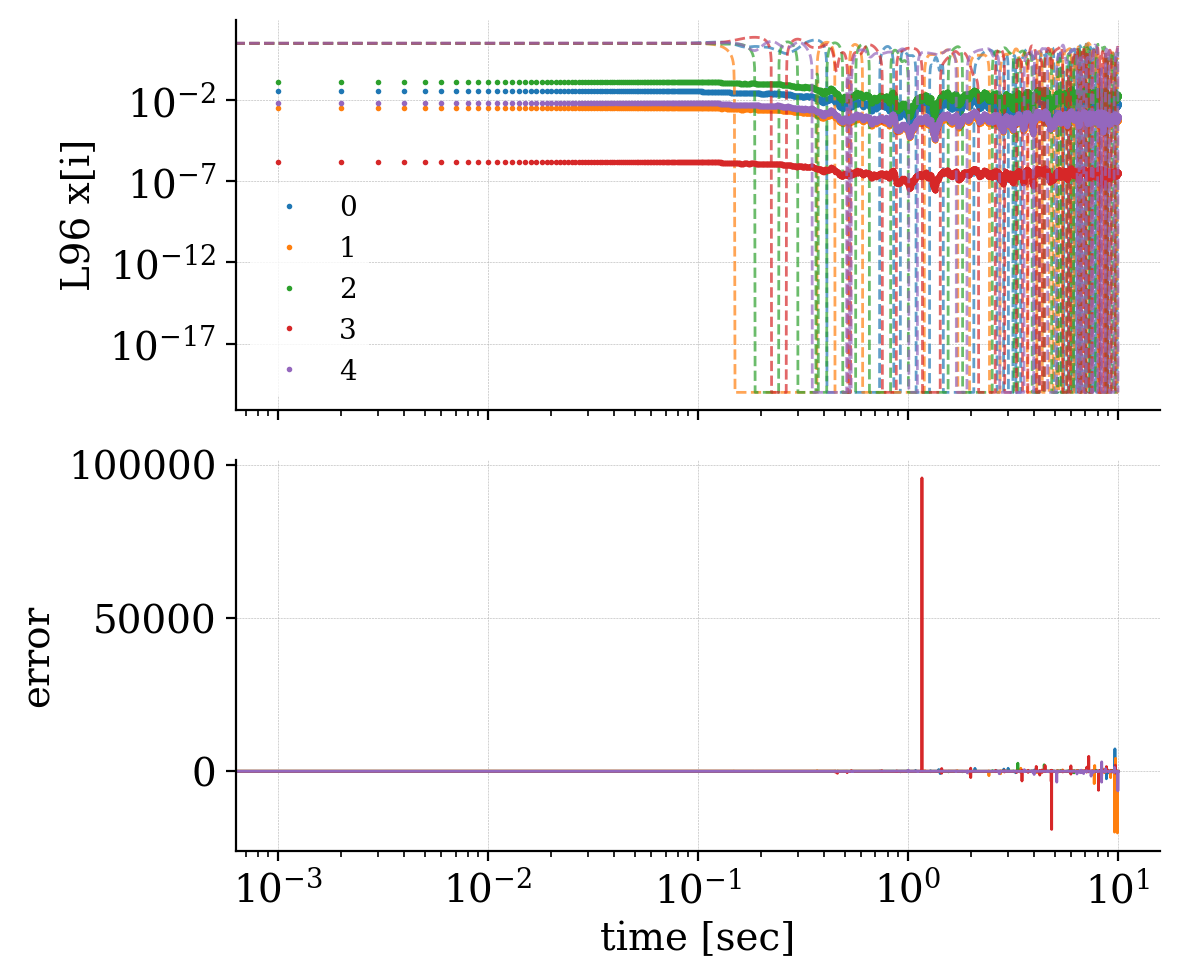

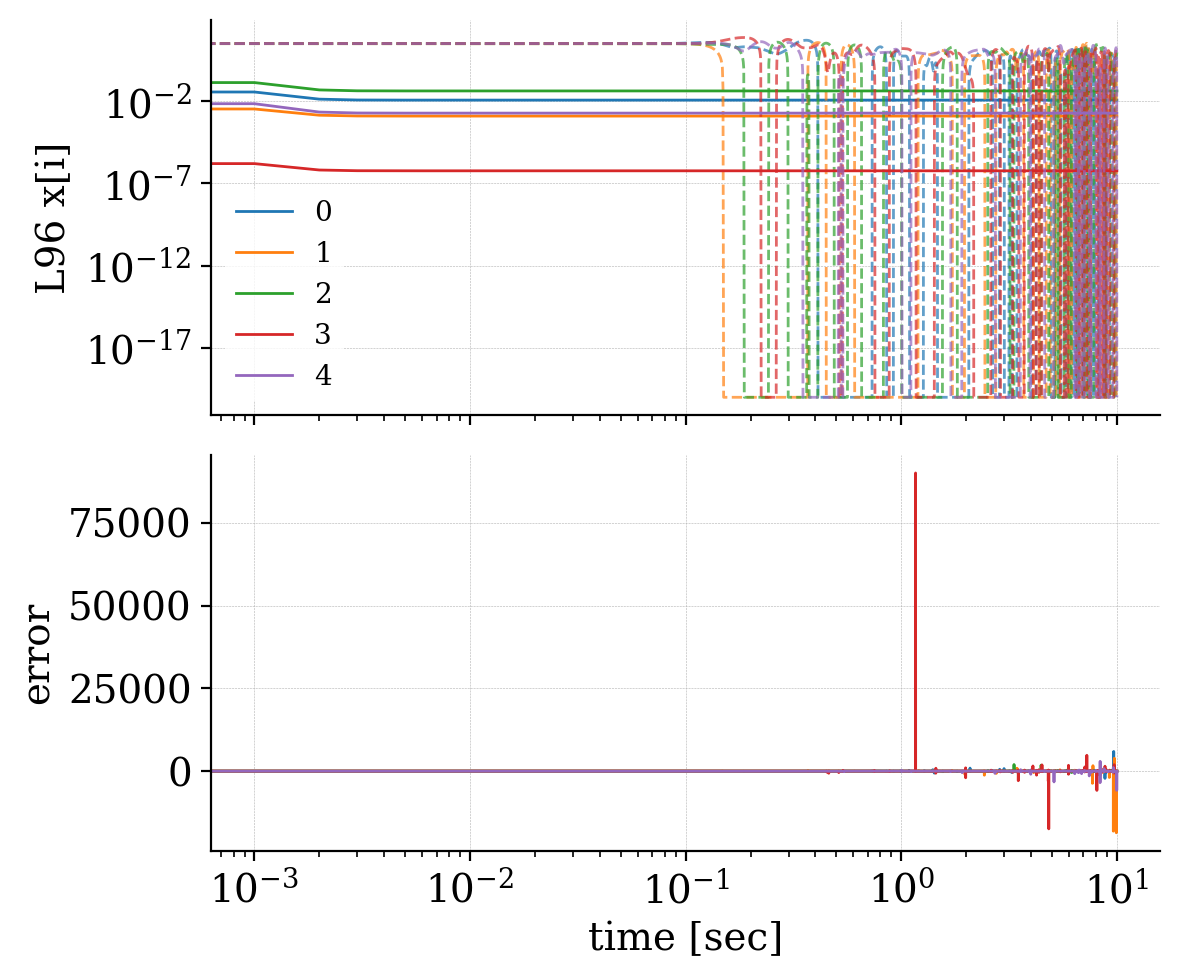

 80%|████████  | 4/5 [01:35<00:24, 24.13s/it]


Errors (following Eq. 23 of Maes et al., 2024):
      Step error: 149.579
 Evolution error: 158.735

>>> Plotting...

Step test plot saved as ./models/20241211_210455/step10.png
Evolution test plot saved as ./models/20241211_210455/evol10.png


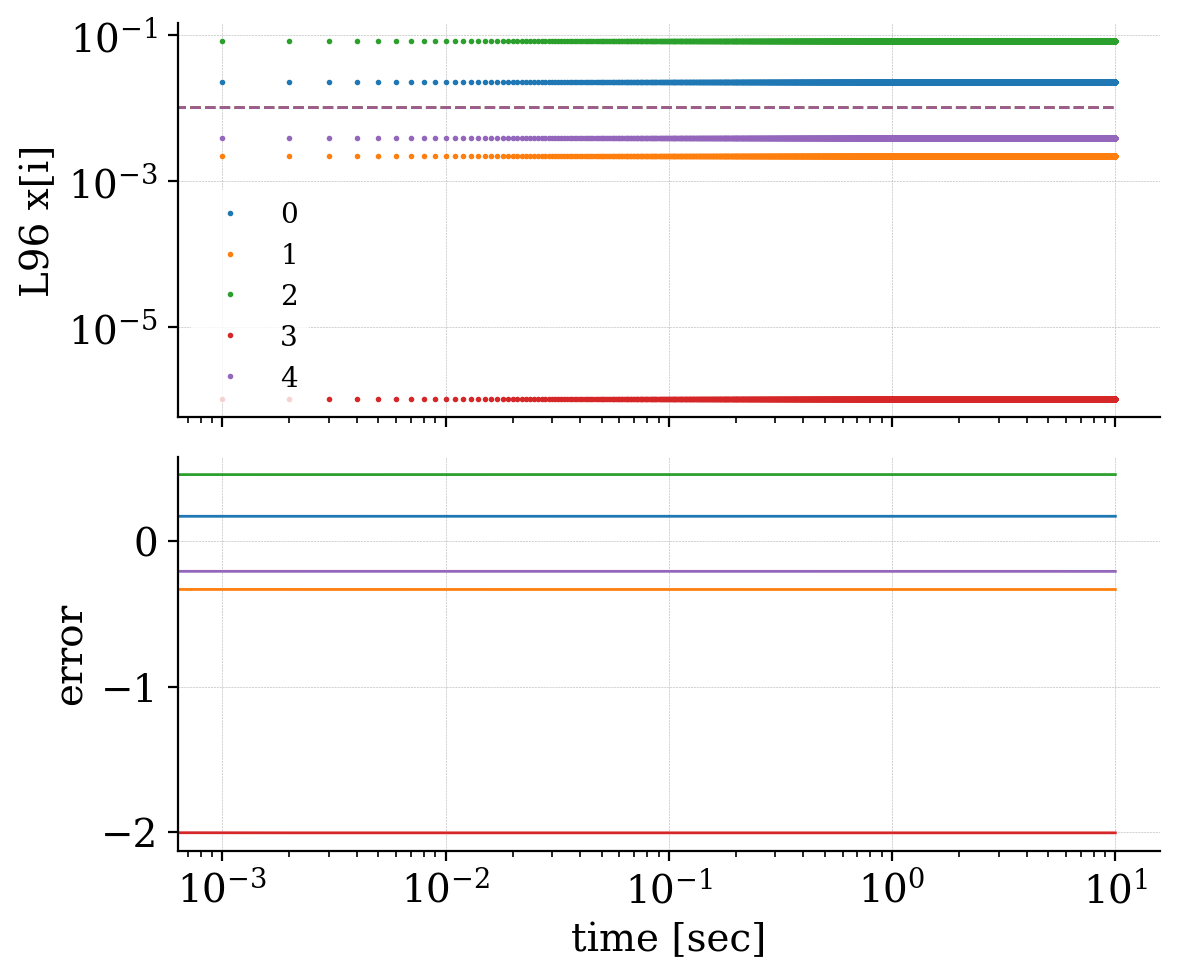

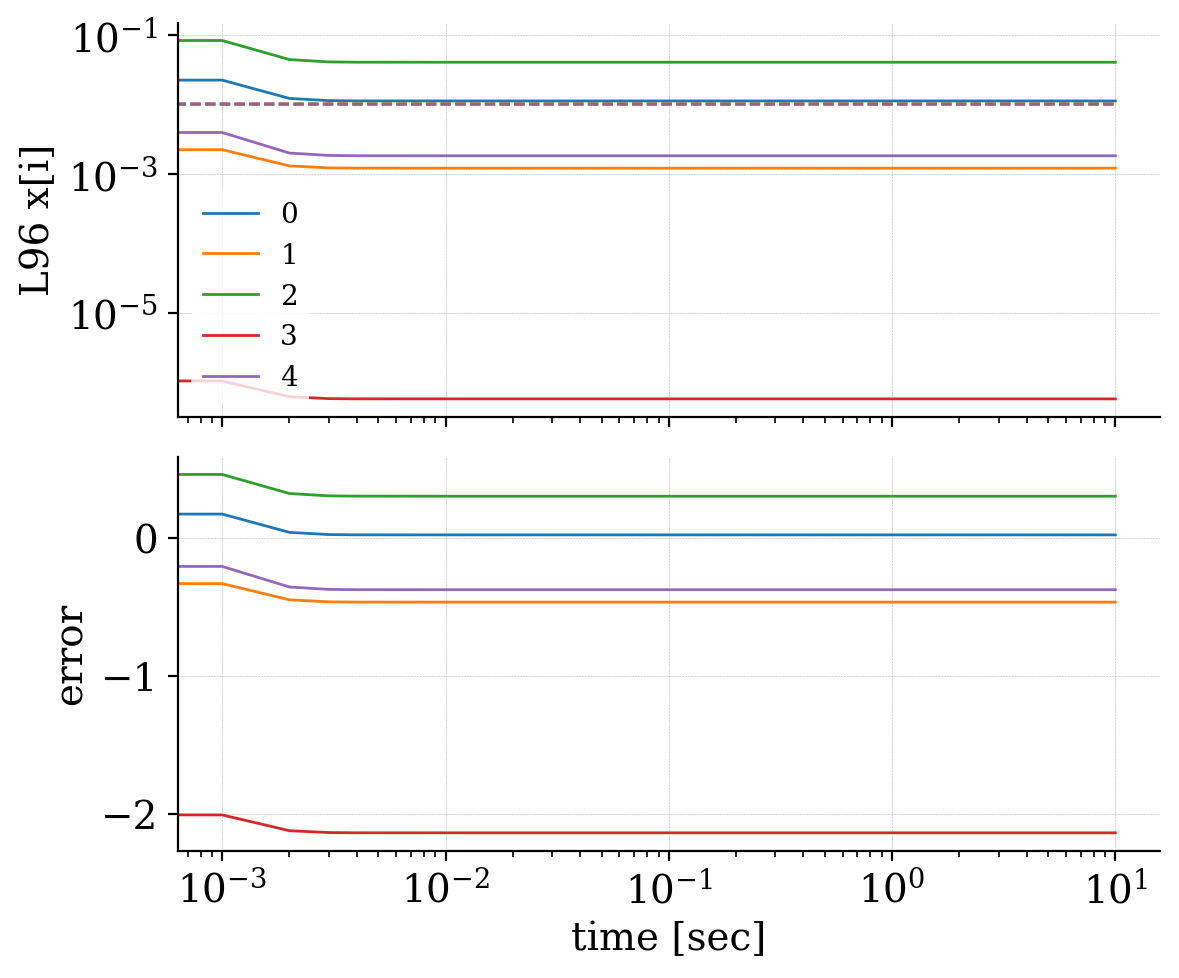

100%|██████████| 5/5 [02:01<00:00, 24.29s/it]


Average error:
           Step: 2069.271
      Evolution: 2023.05
(following Eq. 23 of Maes et al., 2024)

>>> FULLY DONE!
Total time [mins]: 2.05
Output saved in: ./models/20241211_210455 



In [6]:
input_data.print()

sum_err_step = 0
sum_err_evol = 0

step_calctime = list()
evol_calctime = list()

for i in tqdm(range(len(traindata.testF))):
    testF = traindata.testF[i] 
    err_test, err_evol, step_time, evol_time,n, n_hat, n_evol  = test.test_model(
        model,
        input_data.n_dim,
        testF,
        meta,
        printing=False,
        plotting=True,
        save=True,
        )
    sum_err_step += err_test
    sum_err_evol += err_evol

    step_calctime.append(step_time)
    evol_calctime.append(evol_time)

utils.makeOutputDir(path+'/test')

np.save(path+ '/test/sum_err_step.npy', np.array(sum_err_step/len(traindata.testF)))
np.save(path+ '/test/sum_err_evol.npy', np.array(sum_err_evol/len(traindata.testF)))

np.save(path+ '/test/calctime_evol.npy', evol_calctime)
np.save(path+ '/test/calctime_step.npy', step_calctime)  

print('\nAverage error:')
print('           Step:', np.round(sum_err_step,3))
print('      Evolution:', np.round(sum_err_evol,3))
print('(following Eq. 23 of Maes et al., 2024)')

stop_time = time()

print('\n>>> FULLY DONE!')

total_time = stop_time - start_time
utils.print_time(total_time)

print('Output saved in:', path,'\n') 
